In [36]:
import sklearn
import pandas as pd
import numpy as np
import math
from scipy.stats import zscore
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# preproc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, brier_score_loss, log_loss
from sklearn.metrics import classification_report, confusion_matrix 

# post-processing 
from sklearn.calibration import calibration_curve

# import custom functions
import sys
sys.path.append("../")
from projectname import custom_funcs

# SET GLOBAL
RANDOM = 0
TEST_SIZE = 0.2
KEY_THRESH = 0.35


In [37]:

# custom func
def pretty_confusion_matrix(confmat, filename):

    # this creates the matplotlib graph to make the confmat look nicer
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center', fontsize = 30)
       
    # change the labels
    ax.set_xticklabels(['']+['No Mets', 'Mets'])
    ax.set_yticklabels(['']+['No mets', 'Mets'])
    plt.xlabel('Predicted Label', size = 20)
    plt.ylabel('True Label', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks (fontsize = 20)
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

## 1. Prep data

- load data 
- one-hot encode categorical features
- standard scale (zscore) continuous features
- split data into train-val and hold-out test sets 
- stratified CV folds, 5 folds repeated 5x with random sampling

In [38]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_N924.csv")
df.shape

(924, 9)

In [39]:

outcome = df['metastasis']
features = df.drop(columns =['metastasis'])
features['AGE'] = features.AGE.astype('float')
features['tumor_site'] = features.tumor_site.astype("category")
features.dtypes

AGE                     float64
SEX                       int64
tumor_size_bins_cm      float64
tumor_site             category
immuno_suppressed         int64
tumor_lymphocytes         int64
lymph_vasc_invasion       int64
tumor_depth             float64
dtype: object

In [40]:
# DEFINE PREPROCESSING 
num_features = ['AGE', 'tumor_size_bins_cm', 'tumor_depth']
cat_features = ['tumor_site']

# Build a preprcessing pipeline for numeric variables
num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler())])
    # Build a preprocessing pipeline for categorical variables
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Instantiate a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)],
    remainder = 'passthrough')

# Generate the preprocessor
preprocessed_X = preprocessor.fit_transform(features)

check_preproc = pd.DataFrame(preprocessed_X)
check_preproc.shape

(924, 11)

In [41]:
# preprocessing outside pipeline for now.
#one_hot_tumor_site = pd.get_dummies(features['tumor_site'], prefix =  "tumor_site")
#features = features.drop(columns = ['tumor_site'])
#features = pd.concat([features, one_hot_tumor_site], axis = 1)

# standardized continuous features
#features['AGE'] = zscore(features.AGE, ddof=1)
#features['tumor_depth'] = zscore(features.tumor_depth, ddof = 1)
#features['tumor_size_bins_cm'] = zscore(features.tumor_size_bins_cm, ddof=1)


In [42]:
# split into train-test split, 
X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                          outcome,
                                                          random_state = 0)
# make cross val folds - 
CV_folds =  RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats =  5,  
                                    random_state = 0)

## 2. Set up models 
###  Logistic Regression Variants
Testing three linear logistic reg variants: 
- L1 regularization = lasso (coefficients shrunk to zero, feature selection)
- L2 regularization = ridge (coefficients shrink to tiny sizes) *default l2, C = 0.1*
- elastic net = best of both 

Other notes:
- Solver = 'saga' because it supports all 3 model types
- Maintaining the balanced weights moving forward
- increasing max number of iterations to 1000 so models converge

### SVM
- because why not 
- need a better reason here.

### Random forest
- allows for non-linear interactions between features
- might have advantage given bootstrap sampling...
- usually just does better.

In [43]:
# DEFINE MODELS

# need to explictly say "penalty = none"
Logistic = LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                             penalty = 'none', 
                              solver = 'saga', 
                             random_state = RANDOM)
Lasso_L1 = LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                             penalty = 'l1', 
                              solver = 'saga', 
                             random_state = RANDOM)
Ridge_L2 = LogisticRegression(class_weight = 'balanced',
                              max_iter = 1000,
                              penalty = 'l2', 
                              solver = 'saga',  
                             random_state =  RANDOM)
Elastic_net = LogisticRegression(class_weight = 'balanced', 
                                 penalty = 'elasticnet',
                                 solver = 'saga', 
                                 l1_ratio = 0.01,
                                 max_iter = 1000, 
                                 random_state = RANDOM)
SVM = SVC (kernel = "rbf",
          class_weight = 'balanced',
          probability = True,
          random_state = RANDOM)

RF = RandomForestClassifier(class_weight = 'balanced',
                           random_state = RANDOM)

In [44]:
# DEFINE PIPELINES so that preproc will be done within each CV fold 
Logit_pipe = Pipeline(steps = [('preproc', preprocessor),
                              ('model', Logistic)])
Lasso_pipe = Pipeline(steps = [('preproc', preprocessor),
                              ('model', Lasso_L1)])
Ridge_pipe = Pipeline(steps = [('preproc', preprocessor),
                               ('model', Ridge_L2)])
Elastic_pipe = Pipeline(steps = [('preproc', preprocessor),
                                 ('model', Elastic_net)])
SVM_pipe = Pipeline(steps = [('preproc', preprocessor),
                             ('model', SVM)])
RF_pipe = Pipeline(steps = [('preproc', preprocessor),
                            ('model', RF)])

Lasso_pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'tumor_size_bins_cm',
                                                   'tumor_depth']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tumor_site'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    penalty='l1', random_state=0,
                                    solver='saga'))])

In [45]:
## DEFINE SCORES 
score_list = {'acc': 'accuracy',
              'precision' : 'precision',
              'recall': 'recall', 
               'f1': 'f1',
              'roc_auc': 'roc_auc', 
             'brier_score_loss': 'brier_score_loss'}

## 3.  Fit models with grid search  CV

#### 3.1 Define hyper-parameters
For linear models 
- tuning the amount of penalization / lambda/ C
- larger C = less regularization
- smaller C = more regularization (more coefficients to zero)
- default Logistic Regression in sklearn has C = 0.1, l2 regularization (ridge)

For Random forest
- tuning minimum samples per leaf 
- controls tree depth

In [46]:
# larger C = less regularization
# default = 1.0 
param_grid_C = {'model__C': [0.001, 0.01, 0.1, 1, 10] }
param_grid_RF = {'model__max_depth': [25, 50, 75, 100]} # max depth of the tree
                # 'max_features' : ['auto', 'sqrt'], # number of features considered at each split
                # 'min_samples_leaf' : [2, 5, 10], # minimum samples contained at each end node
                 #'min_samples_split': [2, 5, 10], # how small is  a node allowed to be before it's split
                 #'n_estimators': [500, 1000] # number of trees - hw many resampled iterations.
               

In [47]:
# there is actually no penalty so this souldn't work. 
Logit_grid = GridSearchCV(Logit_pipe,
                    param_grid = param_grid_C, 
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)


Lasso_grid = GridSearchCV(Lasso_pipe,
                    param_grid = param_grid_C, 
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

Ridge_grid = GridSearchCV(Ridge_pipe,
                    param_grid = param_grid_C,                    
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

Elastic_grid = GridSearchCV(Elastic_pipe,
                    param_grid = param_grid_C,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

SVM_grid = GridSearchCV(SVM_pipe,
                    param_grid = param_grid_C,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

RF_grid = GridSearchCV(RF_pipe,
                    param_grid = param_grid_RF,
                    return_train_score = True,
                    cv = CV_folds, 
                    scoring = score_list,
                    refit = "precision",
                    n_jobs =  -1)

#### 3.2  Run loop for each classification grid

In [48]:

# list of names
classifier_names = ['Logistic Regression', 'Lasso Regression',
                    'Ridge Regression',  'Elastic net',
                    'Support Vector Machine', 'Random Forest']
# list of pipelines for each model
classifiers = [Logit_grid, Lasso_grid, Ridge_grid, Elastic_grid, 
               SVM_grid, RF_grid]

# fit each grid and save metrics.
i = 0
grid_results = pd.DataFrame()
for classifier in classifiers:
    classifier.fit(X_trainval, y_trainval)
    # get the results and store them!
    results = pd.DataFrame(classifier.cv_results_)
    results['model'] = classifier_names[i]
    print(classifier_names[i])
    print(results.shape)
    i = i + 1
    grid_results = pd.concat([grid_results, results], ignore_index = True)



/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Logistic Regression
(5, 337)
Lasso Regression
(5, 337)
Ridge Regression
(5, 337)
Elastic net
(5, 337)
Support Vector Machine
(5, 337)
Random Forest
(4, 337)


In [49]:
grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__C', 'params', 'split0_test_acc', 'split1_test_acc',
       'split2_test_acc', 'split3_test_acc',
       ...
       'split19_train_brier_score_loss', 'split20_train_brier_score_loss',
       'split21_train_brier_score_loss', 'split22_train_brier_score_loss',
       'split23_train_brier_score_loss', 'split24_train_brier_score_loss',
       'mean_train_brier_score_loss', 'std_train_brier_score_loss', 'model',
       'param_model__max_depth'],
      dtype='object', length=338)

#### 3.3 Get grid search CV model results 

In [50]:
# get log  of C for easier visualization
grid_results['param_model__C']= grid_results.param_model__C.astype('float')
grid_results['log_C'] = grid_results.param_model__C.map(lambda x: math.log(x))
grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__C', 'params', 'split0_test_acc', 'split1_test_acc',
       'split2_test_acc', 'split3_test_acc',
       ...
       'split20_train_brier_score_loss', 'split21_train_brier_score_loss',
       'split22_train_brier_score_loss', 'split23_train_brier_score_loss',
       'split24_train_brier_score_loss', 'mean_train_brier_score_loss',
       'std_train_brier_score_loss', 'model', 'param_model__max_depth',
       'log_C'],
      dtype='object', length=339)

In [51]:
# compile results into neater format

grid_results = grid_results[['model', 'param_model__C', 'log_C', 'param_model__max_depth',
                             'mean_train_f1', 'mean_test_f1', 
                             'mean_train_precision', 'mean_test_precision',
                             'mean_train_recall', 'mean_test_recall', 
                             'mean_train_acc', 'mean_test_acc', 
                             'mean_train_roc_auc', 'mean_test_roc_auc', 
                             'mean_train_brier_score_loss', 'mean_test_brier_score_loss']]
# reshape data from wide to long
grid_results_long = pd.melt(grid_results, 
                            id_vars = ['model', 'param_model__C', 'log_C', 'param_model__max_depth'], 
                            value_vars = ['mean_train_f1', 'mean_test_f1', 
                                          'mean_train_precision', 'mean_test_precision',
                                          'mean_train_recall', 'mean_test_recall',
                                          'mean_train_acc','mean_test_acc', 
                                          'mean_train_roc_auc', 'mean_test_roc_auc',
                                          'mean_train_brier_score_loss', 'mean_test_brier_score_loss'],
                                          
                           var_name = 'metric', 
                           value_name = 'score')

# add indicator for train vs. tteam
#apply(lambda x: 0 if x == 1 else 1)
grid_results_long['dataset'] = grid_results_long.metric.str.contains("train").\
apply(lambda x: "Train" if x == True else "Validation")
# get rid of prefix 
grid_results_long["metric"] = grid_results_long.metric.str.replace('mean_test_', "").str.replace('mean_train_', "")


In [52]:
# chunk by metric 
accuracy_results =  grid_results_long[(grid_results_long.metric == "acc")]
recall_results = grid_results_long[(grid_results_long.metric == "recall")]
precision_results = grid_results_long[(grid_results_long.metric == "precision")]
f1_score_results = grid_results_long[(grid_results_long.metric == "f1")]
roc_auc_score_results = grid_results_long[(grid_results_long.metric == "roc_auc")]
brier_score_results = grid_results_long[(grid_results_long.metric == "brier_score_loss")]
random_forest_results = grid_results_long[grid_results_long.model == "Random Forest"]

brier_score_results.head()

,model,param_model__C,log_C,param_model__max_depth,metric,score,dataset
290,Logistic Regression,0.001,-6.907755,NaN,brier_score_loss,-0.230519,Train
291,Logistic Regression,0.010,-4.605170,NaN,brier_score_loss,-0.230519,Train
292,Logistic Regression,0.100,-2.302585,NaN,brier_score_loss,-0.230519,Train
293,Logistic Regression,1.000,0.000000,NaN,brier_score_loss,-0.230519,Train
294,Logistic Regression,10.000,2.302585,NaN,brier_score_loss,-0.230519,Train


### 3.4 Inspect learning curves  
comparing train vs. validation scores across grid search CV
- we can see that changing value of C makes a big difference for lasso and SVM, but not the other two models.

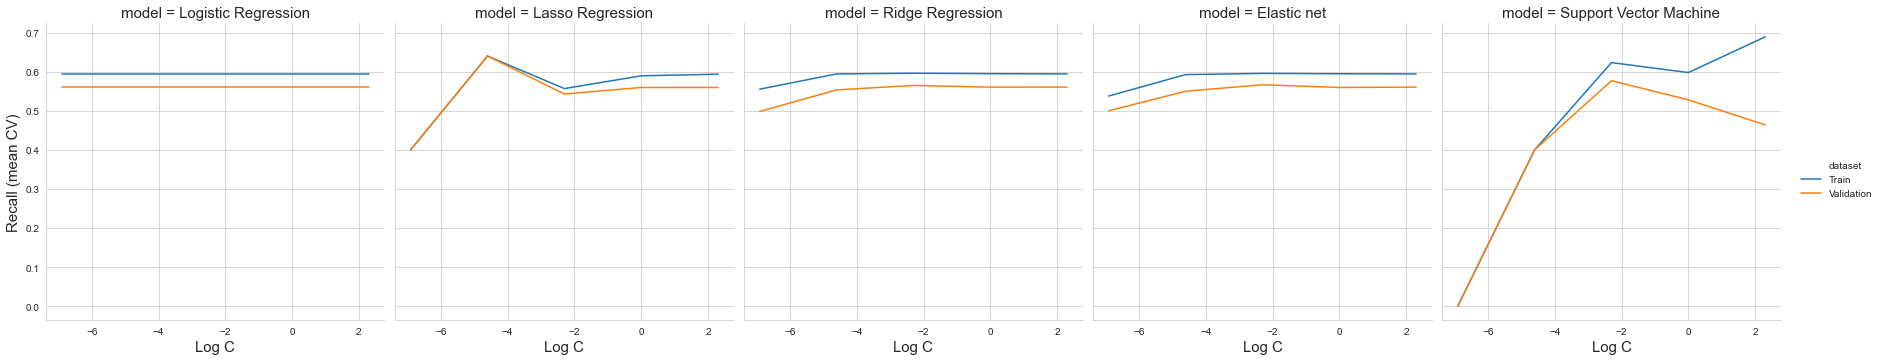

In [53]:
# figure of model comparisons on training  
g = sns.relplot(data = recall_results[recall_results.model != "Random Forest"], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset",  kind = "line", 
                col = "model")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("Recall (mean CV)", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_8_features_results/grid_CV_recall.png', bbox_inches = 'tight')

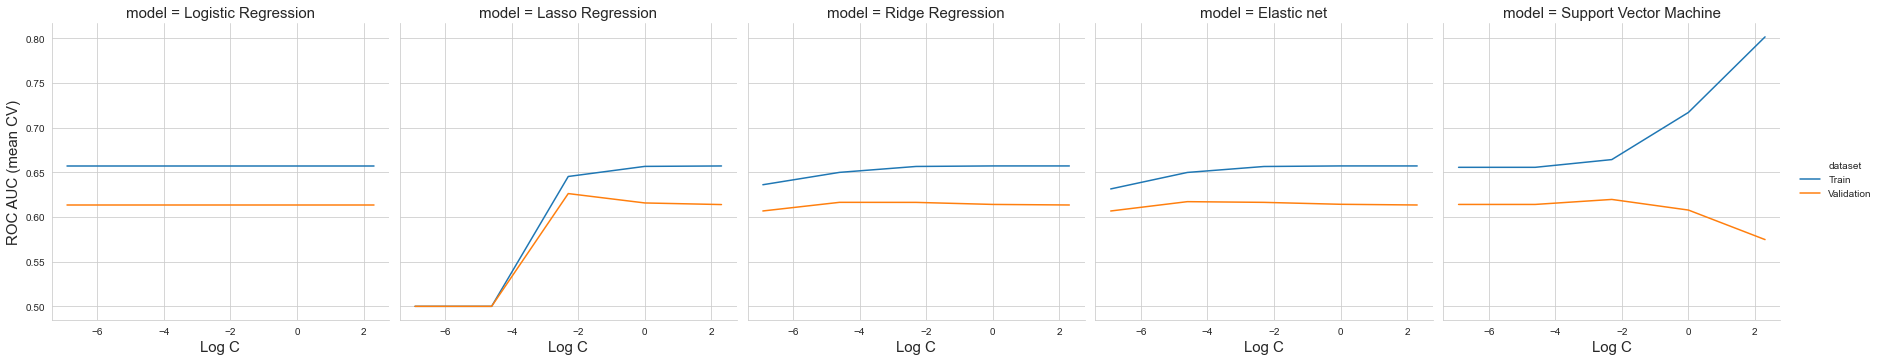

In [54]:
# figure of model comparisons on training  
g = sns.relplot(data = roc_auc_score_results[roc_auc_score_results.model != "Random Forest"], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "model")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("ROC AUC (mean CV)", size = 15)
g.set_titles(size = 15)

plt.savefig('../figures/NCDB_8_features_results/grid_CV_roc_auc.png', bbox_inches = 'tight')

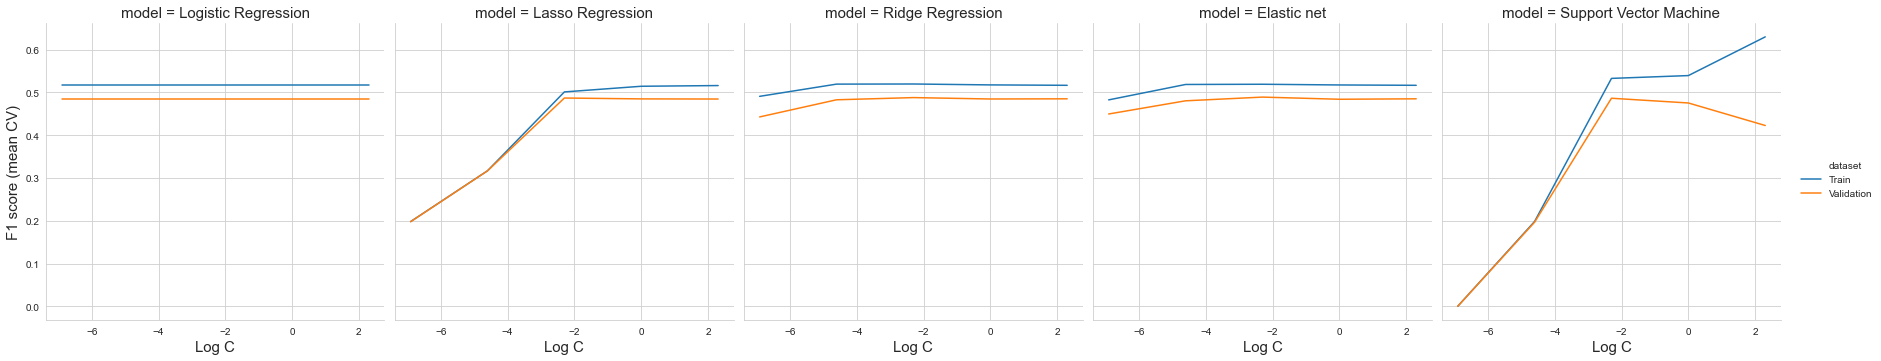

In [55]:
# figure of model comparisons on training  
g = sns.relplot(data = f1_score_results[f1_score_results.model != "Random Forest"], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "model")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("F1 score (mean CV)", size = 15)
g.set_titles(size = 15)
plt.savefig('../figures/NCDB_8_features_results/grid_CV_f1_Score.png', bbox_inches = 'tight')

### Inspect random forest separately...
different parameters,  and has an over-fitting problem!! 

In [56]:
#RF_only = grid_results[grid_results.model == "Random Forest"]
#best_RF = RF_only.mean_test_recall.max()
#best_RF = pd.DataFrame(RF_only[RF_only.mean_test_recall == best_RF])

#print("Best RF Recall: {}".format(best_RF.round(2)))
#display(best_RF)


In [57]:
g = sns.relplot(data = random_forest_results,
                x = "model__max_depth", y = "score", 
                 hue = "dataset", kind = "line", 
                height =  4, aspect = 1.5)
g.set_xlabels("max", size = 15)
g.set_ylabels("ROC AUC (mean CV)", size = 15)
plt.title("Tuning Random Forest ", size = 15);
#g.set(xlim=(1,5), ylim=(.4, .7))


ValueError: Could not interpret input 'model__max_depth'

### 3.6 Probability calibration 
**Brier score loss**
 - comparing how the models do with regard to calibration of probabilities
 - mean squared error between predicted probabilities and expected values
 - lower score = better match to perfect calibration
 - score that doesn't involve binary classes!
 
 something is wrong here, because it 's iimpossible to have negative values.

In [ ]:

#lower brier score = better 
g = sns.relplot(data = brier_score_results[brier_score_results.model != "Random Forest"], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset", 
                kind = "line", col = "model")
g.set_xlabels("Log C", size = 15)
g.set_ylabels("Brier score (mean CV)", size = 15)
g.set_titles(size = 15)
plt.savefig('../figures/NCDB_8_features_results/grid_CV_brier_Score.png', bbox_inches = 'tight')

### 3.5 Compare models across all  scores, validation only 

In [ ]:
g = sns.relplot(data = grid_results_long[grid_results_long.dataset == "Validation"], 
                x = "log_C", y = "score", 
                hue = "model", col = "metric",
                kind = "line", col_wrap = 3)
g.set_xlabels("Log C", size = 15)
g.set_ylabels("Score", size = 15)
g.set_titles(size = 15)

## 4. Evaluate the best model
- fit the final model, with all of the training data
- run on hold-out test data.

### 4.1 find best model from all grids
- using Recall as top-line metric for model selection


In [90]:
best_metric = grid_results['mean_test_recall'].max()
best_model = pd.DataFrame(grid_results[grid_results['mean_test_recall']== best_metric])

print("Best Recall: {}".format(best_metric.round(2)))
print("Best model: {}".format(best_model['model']))
print("Best C parameter: {}".format(best_model['param_model__C']))


Best Recall: 0.64
Best model: 6    Lasso Regression
Name: model, dtype: object
Best C parameter: 6    0.01
Name: param_model__C, dtype: float64


###  4.2 Fit the best model on test data

In [58]:
# define and fit the model 
best_LR_model = LogisticRegression(class_weight = 'balanced', max_iter = 1000,
                                       penalty = 'l1', solver = 'saga',
                                        C = 0.1)

# applying the preprocessing to the X_trainval and X_test 
preproc_X_trainval = preprocessor.fit_transform(X_trainval)
preproc_X_test = preprocessor.fit_transform(X_test)

# fit the model to the entire train-validation set
best_LR_model.fit(preproc_X_trainval, y_trainval)

# get predictions on hold-out test set.
y_pred = best_LR_model.predict(preproc_X_test)
y_pred_prob = pd.DataFrame(best_LR_model.predict_proba(preproc_X_test))[1]

# get scores 
best_test_scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc", "accuracy", "f1 score"],
                            "scores" : [precision_score(y_test, y_pred), 
                                       recall_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_pred),
                                        accuracy_score(y_test, y_pred),
                                       f1_score(y_test, y_pred)]
                           })
best_test_scores['scores'] = best_test_scores.scores.round(3)

print("Best Model scores on hold-out test set")
display(best_test_scores)

Best Model scores on hold-out test set


,metrics,scores
0,precision,0.511
1,recall,0.613
2,roc_auc,0.666
3,accuracy,0.684
4,f1 score,0.558


### 4.3 inspect the model calibration 

**Log loss** 
-  logistic loss, cross entropy. perfect model = 0, worst model = 1

**Brier score loss**
 - comparing how the models do with regard to calibration of probabilities
 - mean squared error between predicted probabilities and expected values
 - lower score = better match to perfect calibration
 - score that doesn't involve binary classes! 
 
 
 **Note:**
 - actually re-calibrating the predicted prorbabilities is not necessary for logistic regression
 - logistic regression probabilities are already "calibrated" because the model is linear... 
 - re-calibration should only be applied when using non-linear models, like SVM or RF 
 - so if my predicted probablities are bad, it's because my model is bad. 



In [ ]:
loss = log_loss(y_test, y_pred_prob)
print("Log Loss {}".format(round(loss, 3)))

brier_score = brier_score_loss(y_test, y_pred_prob)
print("Brier score {}".format(round(brier_score, 3)))

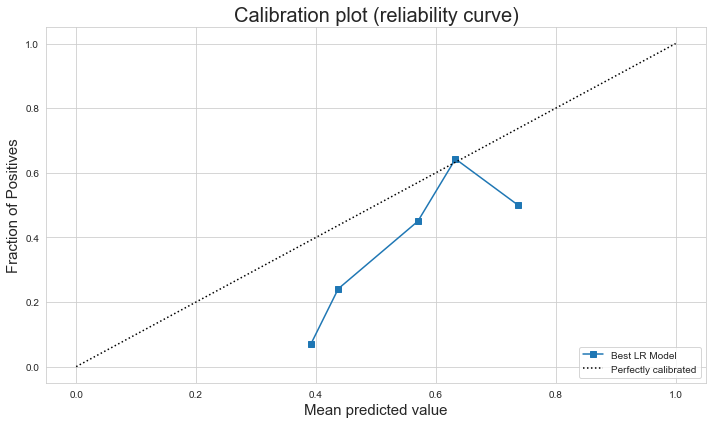

In [59]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_prob, n_bins=10)

plt.figure(figsize = (10,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Best LR Model")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.title('Calibration plot (reliability curve)', size = 20)
plt.xlabel('Mean predicted value', size = 15)
plt.ylabel('Fraction of Positives', size = 15)
plt.legend(loc = "lower right")
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.tight_layout()


### 4.3 Inspect the confusion matrix


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


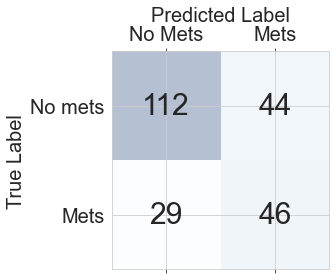

False negatives: Patients mis-classified as low risk, need biopsy: 0.39
False positives: Patients identified as high risk, but don't need biopsy: 0.28
Precision: Of all people recommended for biopsy, how many actually have metastasis? 0.51
Recall: Of all people who actually have metastasis, how many are correctly recommended for biopsy? 0.61


In [60]:
# get our predictions on the test dataset for conversion = 1 or 0

cm = confusion_matrix(y_test, y_pred)
pretty_confusion_matrix(cm, "../figures/NCDB_8_features_results/confusion_matrix_0.5.png")
true_negatives = cm[0,0]
false_negatives = cm[1,0]
true_positives = cm[1,1]
false_positives = cm[0,1]
total_cases = y_test.shape[0]

#classified_negative_rate =  (true_negatives / total_cases)
false_negative_rate = round(false_negatives / (true_positives + false_negatives),2)
false_positive_rate = round(false_positives / (false_positives + true_negatives),2)

precision = round(true_positives / (false_positives + true_positives),2)
recall = round(true_positives / (false_negatives + true_positives),2)
#classified_positive_rate =  (true_positives / total_cases) 
#print("Patients with low risk, no biopsy: {}%".format(round(true_negative_rate,2)))
print("False negatives: Patients mis-classified as low risk, need biopsy: {}".format(round(false_negative_rate, 2)))
#print("Patients identified as high risk, need biopsy: {}%".format(round(true_positive_rate,2)))
print("False positives: Patients identified as high risk, but don't need biopsy: {}".format(round(false_positive_rate,2)))
print ("Precision: Of all people recommended for biopsy, how many actually have metastasis? {}".format(round(precision, 2)))
print ("Recall: Of all people who actually have metastasis, how many are correctly recommended for biopsy? {}".format(round(recall, 2)))

### Tuning predicted probabilities: lower decision-boundary

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


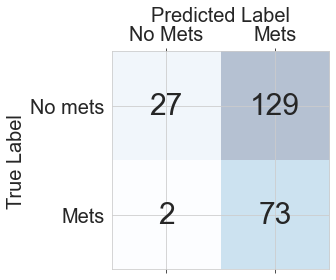

False negatives: Patients mis-classified as low risk, need biopsy: 0.03
False positives: Patients identified as high risk, but don't need biopsy: 0.83
Precision: Of all people recommended for biopsy, how many actually have metastasis? 0.36
Recall: Of all people who actually have metastasis, how many are correctly recommended for biopsy? 0.97


In [61]:
key_thresh = 0.40
y_pred_thresh_lower = y_pred_prob >  key_thresh
cm = confusion_matrix(y_test, y_pred_thresh_lower)
pretty_confusion_matrix(cm, "../figures/NCDB_8_features_results/confusion_matrix_0.4.png")
# CALCULATE STUFF
true_negatives = cm[0,0]
false_negatives = cm[1,0]
true_positives = cm[1,1]
false_positives = cm[0,1]
total_cases = y_test.shape[0]

#classified_negative_rate =  (true_negatives / total_cases)
false_negative_rate = round(false_negatives / (true_positives + false_negatives),2)
false_positive_rate = round(false_positives / (false_positives + true_negatives),2)

precision = round(true_positives / (false_positives + true_positives),2)
recall = round(true_positives / (false_negatives + true_positives),2)
#classified_positive_rate =  (true_positives / total_cases) 
#print("Patients with low risk, no biopsy: {}%".format(round(true_negative_rate,2)))
print("False negatives: Patients mis-classified as low risk, need biopsy: {}".format(round(false_negative_rate, 2)))
#print("Patients identified as high risk, need biopsy: {}%".format(round(true_positive_rate,2)))
print("False positives: Patients identified as high risk, but don't need biopsy: {}".format(round(false_positive_rate,2)))
print ("Precision: Of all people recommended for biopsy, how many actually have metastasis? {}".format(round(precision, 2)))
print ("Recall: Of all people who actually have metastasis, how many are correctly recommended for biopsy? {}".format(round(recall, 2)))


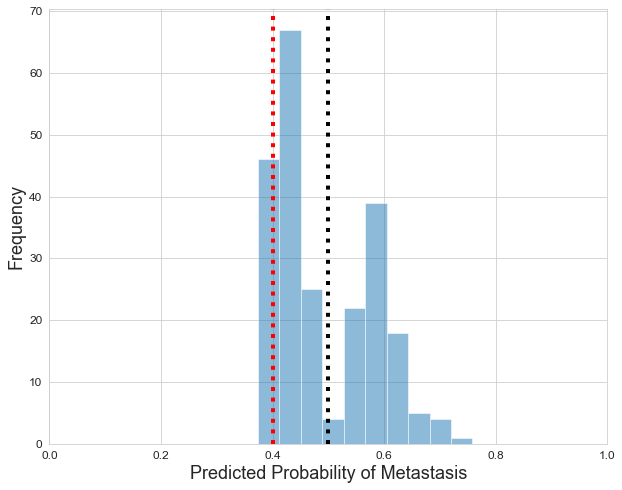

In [62]:
plt.figure(figsize = (10, 8))
plt.hist(y_pred_prob, alpha = 0.5)
plt.axvline(linewidth = 4, color = "red", linestyle = "dotted", x = key_thresh)
plt.axvline(linewidth = 4, color = "black", linestyle = "dotted", x = 0.5)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlim(0, 1)
plt.xlabel("Predicted Probability of Metastasis", size = 18)
plt.ylabel ("Frequency",  size = 18)
plt.savefig("../figures/NCDB_8_features_results/PredProb_NCDB_8_features.png")
plt.show()


### 4.4 ROC curves 

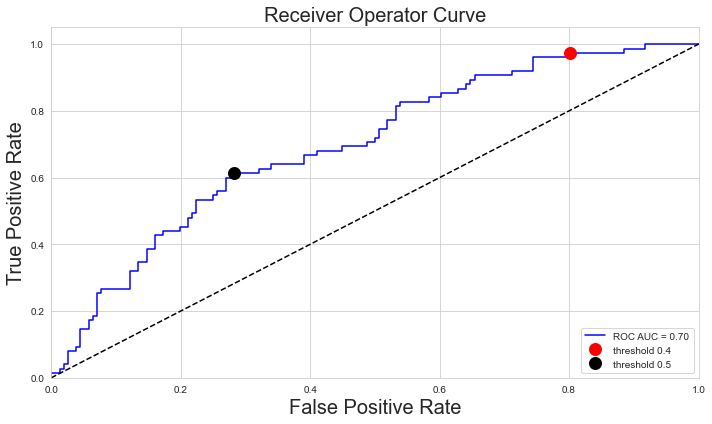

In [63]:
fpr, tpr, thresh = roc_curve(y_test, y_pred_prob)
auc_score = auc(fpr, tpr)
# get thresh
thresh_lower = np.argmin(np.abs(thresh - 0.4))
thresh_default = np.argmin(np.abs(thresh - 0.5))

# plot 
plt.figure(figsize = (10,6))
plt.step(fpr, tpr,  where='post',  color = "blue",
    label='ROC AUC = %0.2f'% auc_score)
plt.plot(fpr[thresh_lower], tpr[thresh_lower], 'o', markersize = 10,
        label = "threshold 0.4", mew = 3, color = "red")
plt.plot(fpr[thresh_default], tpr[thresh_default], 'o', markersize = 10,
        label = "threshold 0.5", mew = 3, color = "black")
plt.plot([0,1], [0,1], color = "black", linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver Operator Curve', fontsize = 20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../figures/NCDB_8_features_results/ROC_curve.png")

    

### 4.5 PR curves

In [64]:
precision, recall, thresh = precision_recall_curve(y_test, y_pred_prob)
pr_auc_score = auc(recall, precision)
# get thresh
thresh_lower = np.argmin(np.abs(thresh - 0.4))
thresh_default = np.argmin(np.abs(thresh - 0.5))


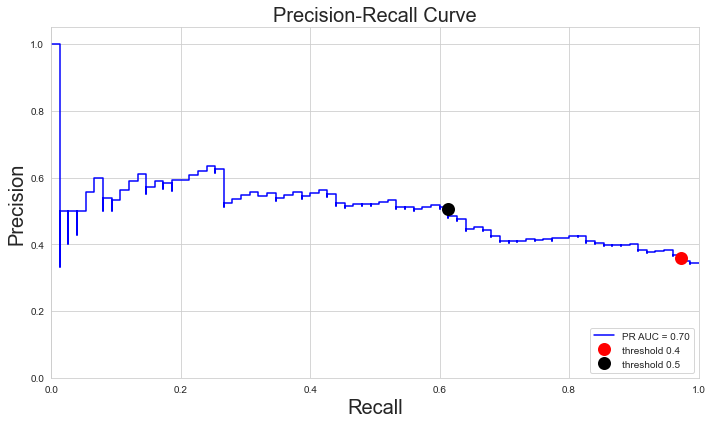

In [65]:

plt.figure(figsize = (10, 6))
plt.step(recall, precision,  where='post',  color = "blue",
    label='PR AUC = %0.2f'% auc_score)
plt.plot(recall[thresh_lower], precision[thresh_lower], 'o', markersize = 10,
        label = "threshold 0.4", mew = 3, color = "red")
plt.plot(recall[thresh_default], precision[thresh_default], 'o', markersize = 10,
        label = "threshold 0.5", mew = 3, color = "black")
plt.xlabel('Recall', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve', fontsize = 20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../figures/NCDB_8_features_results/PR_Curve.png")


### 4.6 Feature importance

In [66]:
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
import warnings
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [67]:
preproc_X_test_df = pd.DataFrame(preproc_X_test)
# apply the function to  get the featture names, because preprocessor mixes up order.
preproc_feature_names = get_feature_names(preprocessor)
preproc_feature_names

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Transformer std_scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available


['num__AGE',
 'num__tumor_size_bins_cm',
 'num__tumor_depth',
 'onehot__x0_extremity',
 'onehot__x0_head_neck',
 'onehot__x0_other',
 'onehot__x0_trunk',
 'SEX',
 'immuno_suppressed',
 'tumor_lymphocytes',
 'lymph_vasc_invasion']

In [68]:

prettier_names = ['Age', 'Tumor size (cm)', 'Tumor depth (mm)', 
                  'Tumor site extremity', 'Tumor site head/neck',
                 'Tumor site other', 'Tumor site trunk',
                 'Sex', 'Immuno suppressed', 'Tumor lymphocytes', 'Lymph vascular invasion']
preproc_X_test_df.columns = prettier_names
# apply custom function to get coefficients from model 
coefs_df = custom_funcs.get_coefs(best_LR_model, preproc_X_test_df)


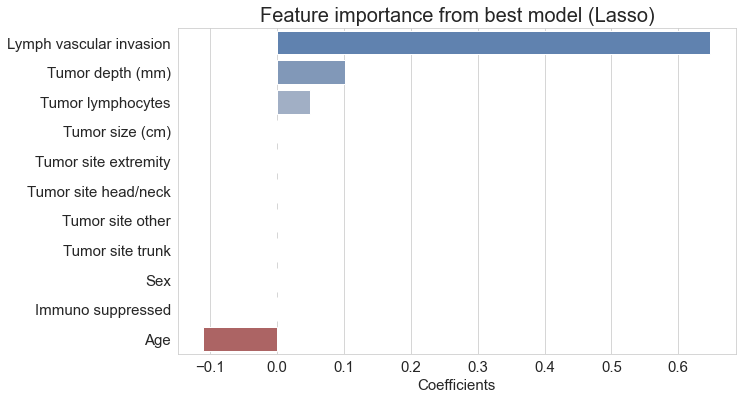

In [69]:

n_features =  coefs_df.shape[0]
plt.figure(figsize =  (10,6))
g = sns.barplot(data = coefs_df, y = 'features', x = "coefs",
            palette = sns.color_palette("vlag", n_features))
g.set_ylabel("")
g.tick_params(labelsize = 15)
g.set_xlabel("Coefficients", size = 15)
g.set_title("Feature importance from best model (Lasso)", size = 20);
plt.savefig('../figures/NCDB_8_features_results/best_LR_feature_weights.png', bbox_inches = 'tight')

 ## get coefficients and p-values from stats models 

In [131]:
import statsmodels.api as sm
# need to explicitly add constant (intercept) to X data 
preproc_X_test_df_int = sm.add_constant(preproc_X_test_df)
y_test_df  = pd.DataFrame(y_test)
preproc_X_test_df_int

TypeError: Index(...) must be called with a collection of some kind, False was passed

In [ ]:

# re-creating best model 
# C = 0.1, so alpha is inverse, should be 10 
log_reg = sm.Logit(y_test_df, preproc_X_test_df_int)
lasso_model = log_reg.fit_regularized(method = 'l1', alpha = 10)
print(lasso_model.summary())


In [124]:

names = pd.DataFrame(prettier_names)
estimates = lasso_model.params
estimates
names

,0
0,Age
1,Tumor size (cm)
2,Tumor depth (mm)
3,Tumor site extremity
4,Tumor site head/neck
5,Tumor site other
6,Tumor site trunk
7,Sex
8,Immuno suppressed
9,Tumor lymphocytes


(array([71., 34., 32., 25., 20., 20., 11., 12.,  4.,  2.]),
 array([0.12804356, 0.19684326, 0.26564297, 0.33444268, 0.40324239,
        0.4720421 , 0.5408418 , 0.60964151, 0.67844122, 0.74724093,
        0.81604064]),
 <BarContainer object of 10 artists>)

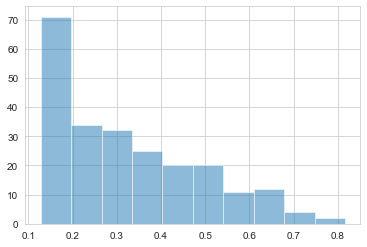

In [83]:
## get predicted probabilities 
logit_y_pred_prob = log_reg.predict(preproc_X_test_int)



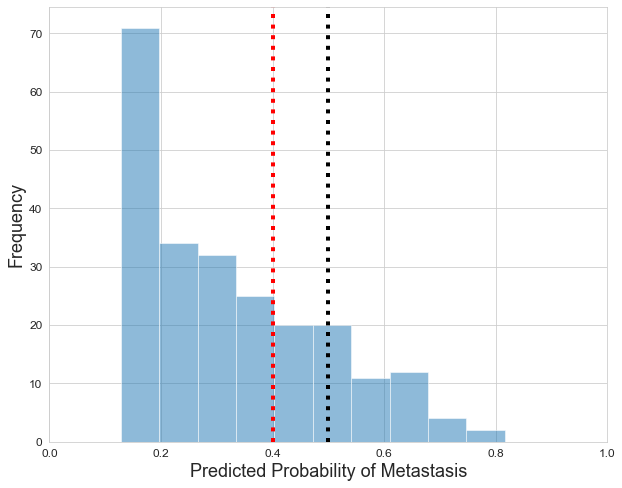

In [84]:
# confusion  

plt.figure(figsize = (10, 8))
plt.hist(logit_y_pred_prob, alpha = 0.5)
plt.axvline(linewidth = 4, color = "red", linestyle = "dotted", x = key_thresh)
plt.axvline(linewidth = 4, color = "black", linestyle = "dotted", x = 0.5)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlim(0, 1)
plt.xlabel("Predicted Probability of Metastasis", size = 18)
plt.ylabel ("Frequency",  size = 18)
#plt.savefig("../figures/NCDB_8_features_results/PredProb_NCDB_8_features.png")
plt.show()


In [81]:

# get predicted classes 
thresh= 0.5
y_pred = log_reg.predict(preproc_X_test_int) > thresh
